# 3 - LDA Model Implementation Using Titiles + Abstracts

In this notebook, we applied the optimized LDA model—previously fine-tuned and saved from Notebook 1 to the title + abstracts dataset. The goal of this experiment was to assess how richer textual input influences topic modeling results. The workflow followed the same steps as outlined in Notebook 1, excluding the hyperparameter fine-tuning phase, as the optimized parameters were directly reused.

In [ ]:
# carbon tracker initialization
from codecarbon import OfflineEmissionsTracker
tracker = OfflineEmissionsTracker(country_iso_code="IRL", project_name="LDA", measure_power_secs=60)
tracker.start()

[codecarbon INFO @ 19:24:50] offline tracker init
[codecarbon INFO @ 19:24:50] [setup] RAM Tracking...
[codecarbon INFO @ 19:24:50] [setup] CPU Tracking...
[codecarbon WARNING @ 19:24:50] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 19:24:50] We saw that you have a Apple M2 but we don't know it. Please contact us.
[codecarbon INFO @ 19:24:50] CPU Model on constant consumption mode: Apple M2
[codecarbon INFO @ 19:24:50] [setup] GPU Tracking...
[codecarbon INFO @ 19:24:50] No GPU found.
[codecarbon INFO @ 19:24:50] >>> Tracker's metadata:
[codecarbon INFO @ 19:24:50]   Platform system: macOS-15.4-arm64-arm-64bit
[codecarbon INFO @ 19:24:50]   Python version: 3.9.18
[codecarbon INFO @ 19:24:50]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 19:24:50]   Available RAM : 8.000 GB
[codecarbon INFO @ 19:24:50]   CPU count: 8
[codecarbon INFO @ 19:24:50]   CPU model: Appl

## Intsallations

In [ ]:
# This script is intended to be run in a Jupyter notebook environment
# such as Google Colab or JupyterLab.

# install dependencies
!pip install -r requirements.txt
# clear output
from IPython.display import clear_output
clear_output()

In [ ]:
import re
import string
import gdown
import warnings
from collections import Counter, OrderedDict
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis.gensim
import scipy as sp
import seaborn as sns
from IPython.display import clear_output
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize
from tqdm.notebook import tqdm

import gensim
from gensim import models, corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import gensim.models.phrases as gen

# Suppress warnings
warnings.filterwarnings('ignore')

# Initialize lemmatizer
lmtzr = WordNetLemmatizer()


[codecarbon INFO @ 19:25:50] Energy consumed for RAM : 0.000050 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:25:50] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:25:50] 0.000759 kWh of electricity used since the beginning.


## Step 1 - Data Loading
Load dataset.

In [ ]:
# download the dataset using gdown
file_id = "1eZpccbF__INfFEYernG2EGPXhhTGOme1"
output_name = "cleaned_dataset.csv"

url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, output_name, quiet=False)

In [ ]:
data = pd.read_csv('cleaned_dataset.csv') # Load the cleaned data
data.head() # Display the first few rows of the dataset

,processed_title,processed_abstract,processed_title_and_abstract
0,population health strategy support hospital in...,country affect number people infect dead first...,population health strategy support hospital in...
1,gis jungle experiential environmental educatio...,travel course build hempel legacy environmenta...,gis jungle experiential environmental educatio...
2,impact american attitude study twitter,past research study social determinant attitud...,impact american attitude study twitter past re...
3,paxlovidtm information guidance member,american society ae official statement provide...,paxlovidtm information guidance member america...
4,upper respiratory tract infection sport immune...,simple summary review clarify relationship hea...,upper respiratory tract infection sport immune...


## Step 2 - Creating Vocabulary Bag-of-Words
Using Abstracts

In [4]:
# changed the following from abstracts to texts
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /Users/sophie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
import ast

# Convert string representations of lists into actual lists
data['processed_title_and_abstract'] = data['processed_title_and_abstract'].apply(lambda x: x.split() if isinstance(x, str) and x else [])

# Now create docs
docs = data['processed_title_and_abstract'].tolist()


In [6]:
 # Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents. Could change to 13%
dictionary.filter_extremes(no_below=20, no_above=0.1) # 10 => 20, 0.2 => 0.1
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initital documents: 128493
Number of unique words after removing rare and common words: 14118


In [7]:
#creating a bag-of-words
len_of_dict = len(dictionary)
corpus = [dictionary.doc2bow(doc) for doc in docs]

bow_doc = corpus[len_of_dict]

print(f"bow_doc: {len(bow_doc)}")


[codecarbon INFO @ 19:26:50] Energy consumed for RAM : 0.000100 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:26:50] Energy consumed for all CPUs : 0.001418 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:26:50] 0.001518 kWh of electricity used since the beginning.


bow_doc: 65


In [8]:
for i in range(len(bow_doc)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc[i][0],
                                                     dictionary[bow_doc[i][0]],
                                                     bow_doc[i][1]))

Word 23 ("healthcare") appears 1 time.
Word 32 ("intensive") appears 1 time.
Word 56 ("resource") appears 1 time.
Word 60 ("service") appears 1 time.
Word 71 ("build") appears 1 time.
Word 72 ("carbon") appears 1 time.
Word 74 ("combine") appears 1 time.
Word 87 ("environmental") appears 3 time.
Word 117 ("travel") appears 4 time.
Word 147 ("interest") appears 1 time.
Word 152 ("opinion") appears 1 time.
Word 241 ("currently") appears 1 time.
Word 295 ("professional") appears 1 time.
Word 301 ("recent") appears 1 time.
Word 341 ("emerge") appears 1 time.
Word 433 ("comprehensive") appears 1 time.
Word 439 ("energy") appears 1 time.
Word 504 ("absence") appears 1 time.
Word 567 ("discuss") appears 1 time.
Word 575 ("focus") appears 1 time.
Word 644 ("future") appears 1 time.
Word 695 ("article") appears 1 time.
Word 699 ("examination") appears 1 time.
Word 823 ("technology") appears 1 time.
Word 999 ("consequently") appears 1 time.
Word 1008 ("emission") appears 1 time.
Word 1078 ("appr

## Step 3 - Create LDA Model

In [9]:
#creating LDA Model
def get_lda_topics(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10)
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

In [ ]:
# get hyperparameters from finetuned model
lda_model = gensim.models.LdaModel.load('lda_model_final.gensim')
num_topics = lda_model.num_topics
alpha = lda_model.alpha
beta = lda_model.eta
print('Number of topics:', num_topics)
print('Alpha:', alpha)
print('Beta:', beta)

Number of topics: 8
Alpha: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
Beta: [1. 1. 1. ... 1. 1. 1.]


In [11]:
# setting the final model, except for the 3 hyperparameters, keeping the rest the same

lda_model_final = gensim.models.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           chunksize=500,
                                           passes=20,
                                           alpha=alpha[0],
                                           eta=beta[0],
                                           per_word_topics=True)  


[codecarbon INFO @ 19:28:50] Energy consumed for RAM : 0.000200 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:28:50] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:28:50] 0.003033 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:29:50] Energy consumed for RAM : 0.000250 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:29:50] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:29:50] 0.003791 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:30:50] Energy consumed for RAM : 0.000300 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:30:50] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:30:50] 0.004549 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:31:50] Energy consumed for RAM : 0.000350 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:31:50] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codeca

## Step 4 - Results

In [12]:
#viewing results
get_lda_topics(lda_model_final, num_topics)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08
0,student,vaccine,mask,policy,ci,protein,cancer,propose
1,participant,vaccination,food,article,mortality,drug,surgery,network
2,survey,antibody,air,service,p,immune,lung,performance
3,mental,variant,concentration,community,death,target,complication,learning
4,online,transmission,surface,crisis,trial,gene,surgical,image
5,anxiety,influenza,energy,economic,child,expression,pain,application
6,education,testing,water,global,admission,receptor,procedure,accuracy
7,child,assay,temperature,management,severity,mechanism,undergo,user
8,self,detection,material,paper,cohort,induce,diagnosis,predict
9,psychological,detect,environmental,world,covid,therapeutic,pulmonary,tool


In [13]:
#enabling visualization
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:
#visualizing using Gensim
vis = pyLDAvis.gensim.prepare(lda_model_final, corpus, dictionary)
pyLDAvis.display(vis)

#optional save
#pyLDAvis.save_html(vis, 'lda.html')

In [15]:
#saving model and specifying how many top words you want
# lda_model.save('model4.gensim')
topics = lda_model_final.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.014*"student" + 0.010*"participant" + 0.009*"survey" + 0.009*"mental" + 0.009*"online" + 0.007*"anxiety" + 0.007*"education" + 0.006*"child" + 0.006*"self" + 0.006*"psychological"')
(1, '0.033*"vaccine" + 0.016*"vaccination" + 0.014*"antibody" + 0.010*"variant" + 0.009*"transmission" + 0.009*"influenza" + 0.008*"testing" + 0.008*"assay" + 0.008*"detection" + 0.007*"detect"')
(2, '0.011*"mask" + 0.010*"food" + 0.008*"air" + 0.006*"concentration" + 0.006*"surface" + 0.006*"energy" + 0.006*"water" + 0.006*"temperature" + 0.005*"material" + 0.004*"environmental"')
(3, '0.007*"policy" + 0.005*"article" + 0.005*"service" + 0.005*"community" + 0.005*"crisis" + 0.005*"economic" + 0.005*"global" + 0.005*"management" + 0.005*"paper" + 0.004*"world"')
(4, '0.017*"ci" + 0.015*"mortality" + 0.010*"p" + 0.008*"death" + 0.008*"trial" + 0.007*"child" + 0.007*"admission" + 0.007*"severity" + 0.006*"cohort" + 0.006*"covid"')
(5, '0.017*"protein" + 0.012*"drug" + 0.008*"immune" + 0.008*"target" + 

## Step 5 - Evaluation

In [16]:
coherences = ['c_v', 'u_mass', 'c_uci', 'c_npmi']
for coherence in coherences:
    if coherence == 'u_mass':
        cm = CoherenceModel(model=lda_model_final, corpus=corpus, dictionary=dictionary, coherence=coherence)
    else:
        cm = CoherenceModel(model=lda_model_final, texts=docs, dictionary=dictionary, coherence=coherence)
    print(f'Coherence Score {coherence}: {cm.get_coherence()}\n')


Coherence Score c_v: 0.6198231019855975

Coherence Score u_mass: -2.3130442113291942



[codecarbon INFO @ 19:33:50] Energy consumed for RAM : 0.000450 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:33:50] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:33:50] 0.006824 kWh of electricity used since the beginning.


Coherence Score c_uci: 0.6133979402868786

Coherence Score c_npmi: 0.07312025238239696



[codecarbon INFO @ 19:34:50] Energy consumed for RAM : 0.000500 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:34:50] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:50] 0.007583 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:35:50] Energy consumed for RAM : 0.000550 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:35:50] Energy consumed for all CPUs : 0.007792 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:50] 0.008341 kWh of electricity used since the beginning.


## Step 6: Save the results

In [17]:
import json

# Create a more structured dictionary to store topic information
topic_data = {
    "model_info": {
        "num_topics": int(num_topics),
        "alpha": float(alpha[0]),
        "beta": float(beta[0]),
        "coherence_score_cv": float(0.6198231019855975)
    },
    "topics": {}
}

# Extract the top words for each topic
for i in range(num_topics):
    topic_words = lda_model_final.show_topic(i, topn=10)  # Get top 10 words for each topic
    
    # Store as a list of word-weight pairs to preserve ranking
    topic_data["topics"][f"Topic_{i+1}"] = {
        "top_words": [{"word": word, "weight": float(weight)} for word, weight in topic_words]
    }

# Save to JSON file
with open('lda_combo_topics.json', 'w') as f:
    json.dump(topic_data, f, indent=4)

print(f"Saved {num_topics} topics with model information to 'lda_combo_topics.json'")

Saved 8 topics with model information to 'lda_combo_topics.json'


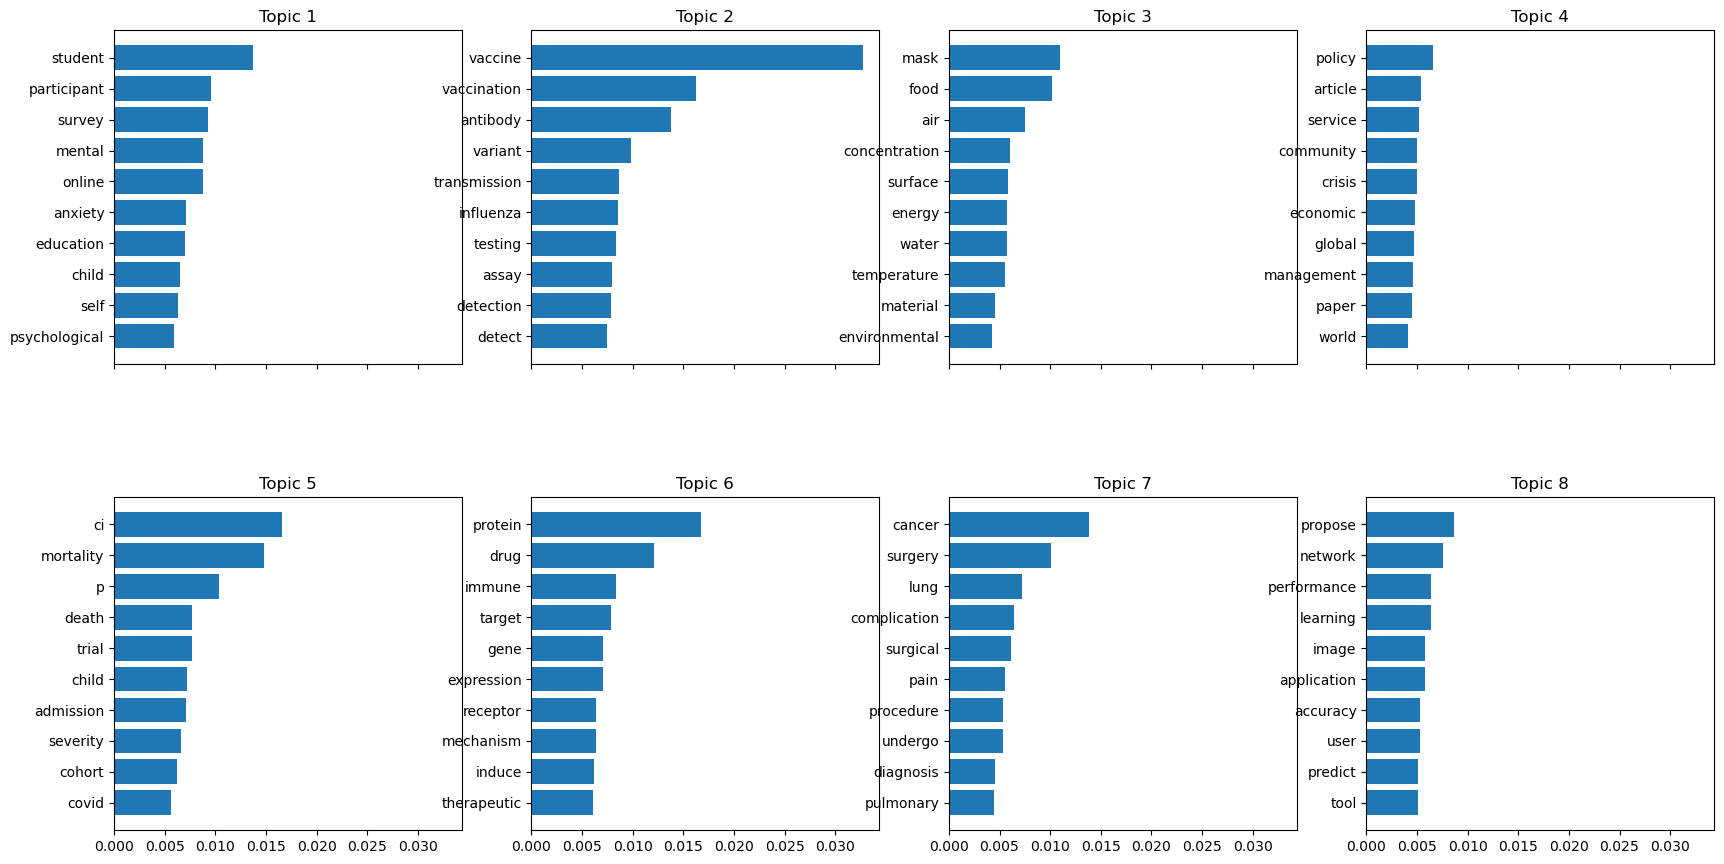

[codecarbon INFO @ 19:36:50] Energy consumed for RAM : 0.000600 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:36:50] Energy consumed for all CPUs : 0.008500 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:36:50] 0.009100 kWh of electricity used since the beginning.


In [ ]:
# Plotting the top words in each topic
def plot_top_words_gensim(model, feature_names, n_top_words):
    # Dynamically calculate the grid size based on the number of topics
    n_rows = (num_topics + 3) // 4  # 4 topics per row
    fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5 * n_rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.show_topics(formatted=False, num_topics=num_topics, num_words=n_top_words)):
        topic_words = topic[1]
        if topic_idx < len(axes):  # Ensure we don't access out-of-bounds axes
            ax = axes[topic_idx]
        # Extract top features (words) and their weights
        top_features = [word for word, weight in topic_words]
        weights = [weight for word, weight in topic_words]
        
        ax.barh(top_features, weights, align='center')
        ax.set_title(f'Topic {topic_idx + 1}')
        ax.invert_yaxis()
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4)
    plt.show()

# Get the feature names from the dictionary
feature_names = dictionary.values()
# Plot the top words in each topic
plot_top_words_gensim(lda_model_final, feature_names, n_top_words=10)

In [19]:
tracker.stop()

[codecarbon INFO @ 19:37:08] Energy consumed for RAM : 0.000614 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:37:08] Energy consumed for all CPUs : 0.008706 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:37:08] 0.009321 kWh of electricity used since the beginning.


0.002710552061112462